<a href="https://colab.research.google.com/github/PedroDubas/Reconhecer_Cancer_Cabeca_img/blob/master/HeadCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!unzip '/gdrive/My Drive/head-ct-hemorrhage.zip' -d '/content/'
!unzip '/content/head_ct.zip' -d '/content/'

In [0]:

##First of all, we are going to load the images and labels
from glob import glob
import os
import pandas as pd 
import cv2
import numpy as np

# Now we define the dimensions of our images.

img_width, img_height = 128, 128

files = sorted(glob('head_ct/*.png'))

labels = pd.read_csv('labels.csv')[' hemorrhage'].tolist()

images = np.empty((len(files), img_width, img_height))

for i, _file in enumerate(files):
    images[i, :, :] = cv2.resize(cv2.imread(_file, 0), (img_width, img_height))
    
print ('\033[1m' + 'Ready for next step!')

Ready for next step!


In [0]:
images.shape

(200, 128, 128)

In [0]:
len(files)

200

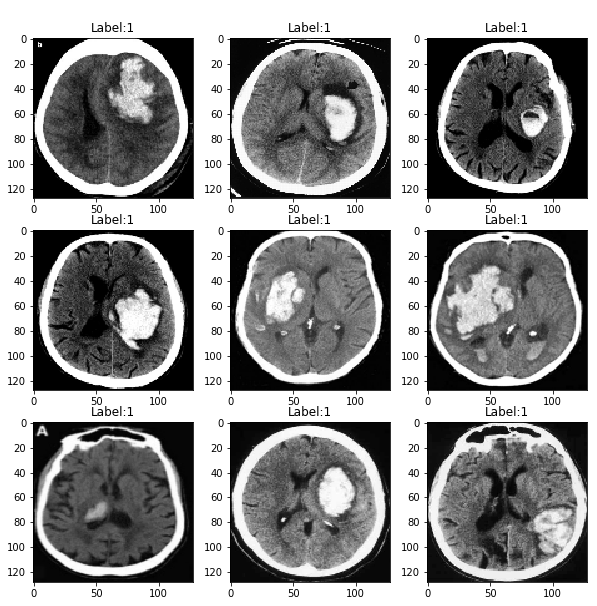

In [0]:
#Let's take a look at the images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.title("\nLabel:{}".format(labels[i]))
# show the plot
plt.show()

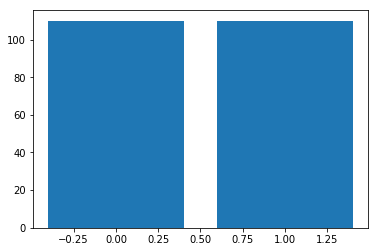

In [0]:
#Let's take a look at the proportion of normal and hemorrhage labels
dum = plt.bar(labels, 110)

In [0]:
#Now we split the dataset into train (80%), validation (10%) and test (10%) sets.
from sklearn.model_selection import train_test_split
import numpy as np

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=1)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=1)

print((len(train_images), len(val_images), len(test_images)))

(160, 20, 20)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K

input_shape = (img_width, img_height, 1)

SIIM_custom_model = None

SIIM_custom_model = Sequential()

#Below we have the first Convolutional Layer

SIIM_custom_model.add(Conv2D(32, (3, 3), input_shape=input_shape))
SIIM_custom_model.add(Activation('relu'))

#We then add a MaxPool layer, which will reduce the size of the output of the first conv layer in 75%.
#This is performed to avoid an exagerated increase in the number of parameters of the network.
#Don't worry if you do not understand in detail each one of these operations right now. Try to focus on the big picture.

SIIM_custom_model.add(MaxPooling2D(pool_size=(2, 2)))

#We will add more convolutional layers, followed by MaxPool layers

SIIM_custom_model.add(Conv2D(32, (3, 3)))
SIIM_custom_model.add(Activation('relu'))
SIIM_custom_model.add(MaxPooling2D(pool_size=(2, 2)))

SIIM_custom_model.add(Conv2D(64, (3, 3)))
SIIM_custom_model.add(Activation('relu'))
SIIM_custom_model.add(MaxPooling2D(pool_size=(2, 2)))

#Finally, we will add two dense layers, or 'Fully Connected Layers'.
#These layers are classical neural nets, without convolutions.

SIIM_custom_model.add(Flatten())
SIIM_custom_model.add(Dense(64))
SIIM_custom_model.add(Activation('relu'))

#Dropout is an overfitting reduction technique.

SIIM_custom_model.add(Dropout(0.5))

#Now, we will set the output o the network.
#The Dense function has the argument "1" because the net output is the hematoma x non-hematoma classification

SIIM_custom_model.add(Dense(1))

#The output is either 0 or 1 and this can be obtained with a sigmoid function.

SIIM_custom_model.add(Activation('sigmoid'))

#Let's compile the network.

SIIM_custom_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print ('\033[1m' + 'Ready for next step!')

Ready for next step!


In [0]:
from numpy.random import seed
seed(1337)
from tensorflow import set_random_seed
set_random_seed(1337)

import warnings
warnings.filterwarnings('ignore')

nb_train_samples = len(train_images)
nb_validation_samples = len(val_images)
epochs = 20
batch_size = 10


# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.0,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(
    train_images[..., np.newaxis],
    train_labels,
    batch_size=batch_size)

validation_generator = val_datagen.flow(
    val_images[..., np.newaxis],
    val_labels,
    batch_size=batch_size)

print ('\033[1m' + 'Ready for next step!')

Ready for next step!


In [0]:
 history = SIIM_custom_model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(val_images) // batch_size)

Epoch 1/20
16/16 [==============================] - 4s 239ms/step - loss: 0.7012 - acc: 0.5688 - val_loss: 0.7040 - val_acc: 0.3500
Epoch 2/20
16/16 [==============================] - 3s 218ms/step - loss: 0.6878 - acc: 0.5563 - val_loss: 0.6463 - val_acc: 0.7500
Epoch 3/20
16/16 [==============================] - 3s 213ms/step - loss: 0.6626 - acc: 0.6437 - val_loss: 0.6551 - val_acc: 0.7000
Epoch 4/20
16/16 [==============================] - 3s 216ms/step - loss: 0.6721 - acc: 0.6125 - val_loss: 0.6199 - val_acc: 0.7000
Epoch 5/20
16/16 [==============================] - 3s 214ms/step - loss: 0.6265 - acc: 0.6563 - val_loss: 0.5619 - val_acc: 0.7500
Epoch 6/20
16/16 [==============================] - 3s 214ms/step - loss: 0.5830 - acc: 0.7313 - val_loss: 0.5913 - val_acc: 0.7000
Epoch 7/20
16/16 [==============================] - 3s 213ms/step - loss: 0.5667 - acc: 0.7000 - val_loss: 0.6318 - val_acc: 0.6500
Epoch 8/20
16/16 [==============================] - 3s 214ms/step - loss: 0.

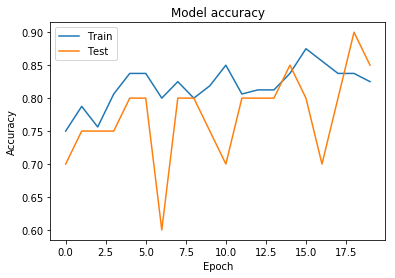

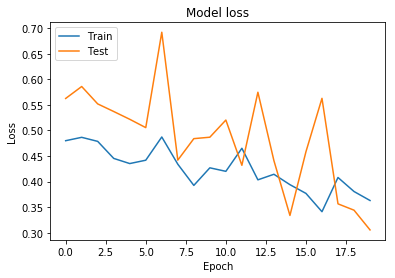

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
#Now we evaluate on the test set. Remember to make pixels between [0, 1] by dividing by 255.

print("Accuracy: " + str(SIIM_custom_model.evaluate(test_images[..., np.newaxis] / 255., test_labels)[1] * 100) + "%")

20/20 [==============================] - 0s 6ms/step
Accuracy: 94.9999988079071%


#Transfer Learning

##Peparando base com 3 canais

In [0]:
train_images.shape

(160, 128, 128)

In [0]:
train_images_3 = np.concatenate([train_images[:,...,np.newaxis], train_images[:,...,np.newaxis], train_images[:,...,np.newaxis]], axis=3)
validation_images_3 = np.concatenate([val_images[:,...,np.newaxis], val_images[:,...,np.newaxis], val_images[:,...,np.newaxis]], axis=3)
test_images_3 = np.concatenate([test_images[:,...,np.newaxis], test_images[:,...,np.newaxis], test_images[:,...,np.newaxis]], axis=3)

In [0]:
train_images_3.shape

(160, 128, 128, 3)

In [0]:
input_shape=(128, 128, 3)
num_classes = 1

from keras.applications import ResNet50
my_new_model = Sequential()
model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)
my_new_model.add(model)
my_new_model.add(Dense(num_classes, activation='softmax'))
my_new_model.layers[0].trainable = False
my_new_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
batch_size=20
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import ceil, floor

checkpointer = ModelCheckpoint(filepath='Melhor_modelo.hdf5', monitor='val_loss', verbose=1, save_best_only=True)


#Com augmentation 
gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 25,
                                  width_shift_range=[-25,25],
                                   horizontal_flip=True)


batches_train = gen.flow(train_images_3, train_labels, batch_size=batch_size)
batches_validation = gen.flow(validation_images_3, val_labels, batch_size=batch_size)

hist = my_new_model.fit_generator(batches_train,
                           epochs=10,
                           validation_data=batches_validation,
                           steps_per_epoch=ceil(1.0*len(train_images_3)/batch_size),
                           validation_steps=ceil(1.0*len(validation_images_3)/batch_size),
                           callbacks=[checkpointer])

Epoch 1/10
8/8 [==============================] - 16s 2s/step - loss: 8.2701 - acc: 0.4813 - val_loss: 5.5798 - val_acc: 0.6500

Epoch 00001: val_loss improved from inf to 5.57983, saving model to Melhor_modelo.hdf5
Epoch 2/10
8/8 [==============================] - 15s 2s/step - loss: 8.2701 - acc: 0.4813 - val_loss: 5.5798 - val_acc: 0.6500

Epoch 00002: val_loss did not improve from 5.57983
Epoch 3/10
8/8 [==============================] - 15s 2s/step - loss: 8.2701 - acc: 0.4812 - val_loss: 5.5798 - val_acc: 0.6500

Epoch 00003: val_loss did not improve from 5.57983
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 8.2701 - acc: 0.4812 - val_loss: 5.5798 - val_acc: 0.6500

Epoch 00004: val_loss did not improve from 5.57983
Epoch 5/10
8/8 [==============================] - 15s 2s/step - loss: 8.2701 - acc: 0.4812 - val_loss: 5.5798 - val_acc: 0.6500

Epoch 00005: val_loss did not improve from 5.57983
Epoch 6/10
8/8 [==============================] - 15s 2s/step - 

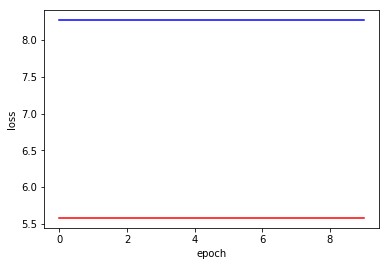

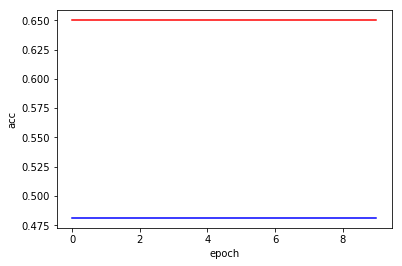

In [0]:
plt.plot(hist.history['loss'], 'b-', label='train loss')
plt.plot(hist.history['val_loss'], 'r-', label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


plt.plot(hist.history['acc'], 'b-', label='train accuracy')
plt.plot(hist.history['val_acc'], 'r-', label='val accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

In [0]:
from keras.models import load_model
melhor_modelo = load_model('Melhor_modelo.hdf5')
print('Acurácia no grupo de teste: ', melhor_modelo.evaluate(test_images_3, test_labels, verbose=1)[1])

20/20 [==============================] - 17s 870ms/step
Acurácia no grupo de teste:  0.5
